In [1]:
import pandas as pd
import numpy as np

from src.populate_db import connect_to_database


# Exploring Band Members

This notebook will answer some basic questions about the members of bands in the database and the instruments they play:
* How many members have the bands had across the years?
* In how many bands the artists were in during their careers?
* What is the most common instrument played/used by the artists in the database?

Let's query the database and load the data into a dataframe.

In [2]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
               SELECT band.name, musician.name, musician.instrument, 
               musician.additional_instrument AS instrument1, 
               musician.additional_instrument2 AS instrument2,
               musician.additional_instrument3 AS instrument3,
               musician.additional_instrument4 AS instrument4 
               FROM musician
               INNER JOIN band_membership ON musician.id = band_membership.musician_id
               INNER JOIN band ON band_membership.band_id = band.id;
               """)
band_members = cursor.fetchall()

We are also replacing some instrument names to avoid multiple labels for the same or similar instruments, in order to simplify the analysis.

In [3]:
instrument_replacements = {
    'electric guitar': 'guitar',
    'keyboard instrument': 'keyboard',
    'eletronic keyboard': 'keyboard',
    'musical keyboard': 'keyboard',
    'percussion instrument': 'percussion',
    'drum kit': 'drum',
    'bass guitar': 'bass'
}

def replace_instrument(col):
    replaced = col.apply(lambda x: instrument_replacements.get(x, x))
    return replaced

In [4]:
band_members_df = pd.DataFrame(band_members, columns=['Band', 'Musician', 'Instrument', 'Instrument1', 'Instrument2', 'Instrument3', 'Instrument4'])
band_members_df = band_members_df[band_members_df['Band'] != '']
band_members_df['Band'] = band_members_df['Band'].str.replace('Ex menber of ', '')
for col in band_members_df.columns[2:]:
    band_members_df[col] = replace_instrument(band_members_df[col])

## How many members have the bands had across the years?

As we can see, many of the bands had only one or two members registered. 

This probably means that the information about members is incomplete for many bands, so let's take a closer look at the top of the list instead.

<Axes: ylabel='Frequency'>

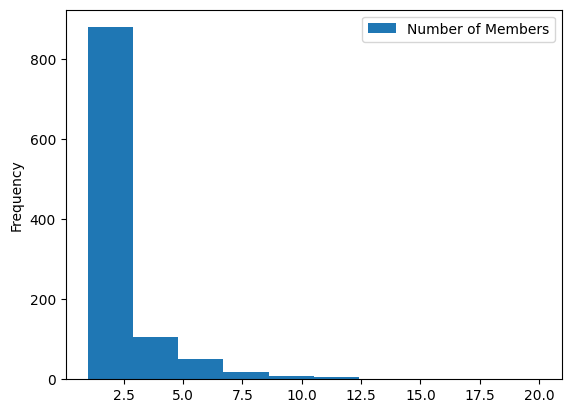

In [5]:
band_members_count = band_members_df.groupby('Band')['Musician'].nunique().reset_index()
band_members_count.columns = ['Band', 'Number of Members']

band_members_count['Number of Members'].plot(kind='hist', legend=True)

According to our data, Megadeth is the band that had the most members across time: 20 musicians.

Next on the list is Mayhem (15), followed by Morning Again completing the top 3 with 14 members.

<Axes: ylabel='Band'>

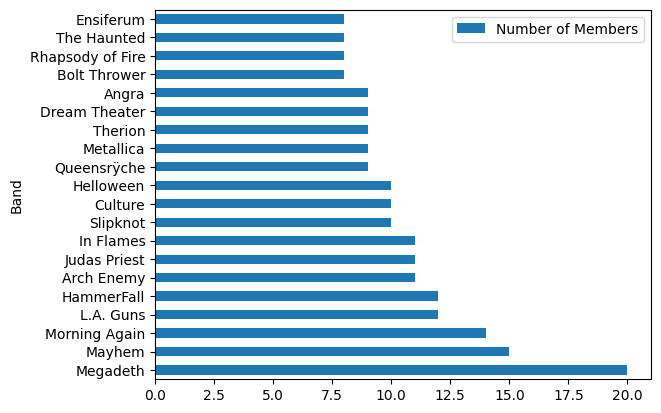

In [6]:
band_members_count.sort_values(by='Number of Members', ascending=False).head(20).plot(kind='barh', x='Band')

## In how many bands the artists were in during their careers?

The data shows that most musicians were part of up to two or three bands in their career.

However, we can also observe a few musicians who were members of multiple bands.

<Axes: ylabel='Frequency'>

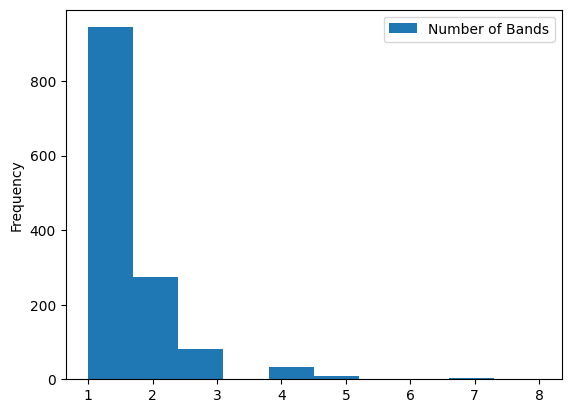

In [7]:
musician_band_count = band_members_df.groupby('Musician')['Band'].nunique().reset_index()
musician_band_count.columns = ['Musician', 'Number of Bands']

musician_band_count = musician_band_count.sort_values(by='Number of Bands', ascending=False)
musician_band_count['Number of Bands'].plot(kind='hist', legend=True)

Let's take a look at the artists with the longer list of bands in their careers.

Rolf Pilve is at the top of the list, having played in 8 bands. Next are Alexi Laiho, Mikko Härkin, and Jukka Koskinen, with 6 bands.

<Axes: ylabel='Musician'>

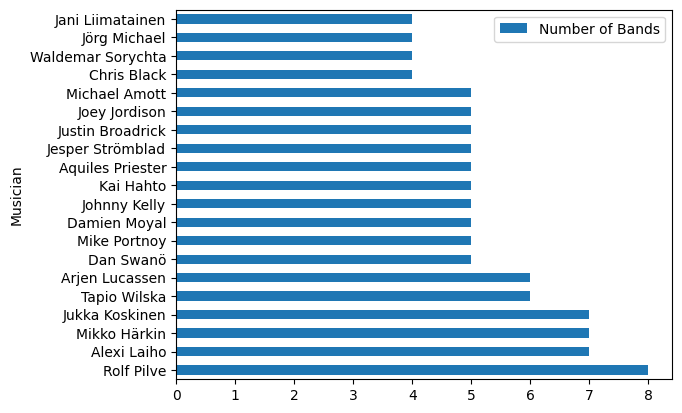

In [8]:
top_musicians = musician_band_count.head(20)
top_musicians.plot(kind='barh', x='Musician')

If we inspect the bands these musicians were part of, it's possible to see some repetitions among them and also some bands that appeared in our previous list of bands with the largest number of members.

In [9]:
for musician in top_musicians['Musician'][:10]:
    bands = band_members_df[band_members_df['Musician'] == musician]['Band'].unique()
    print(f"{musician} played in:\n  - {', '.join(bands)}")

Rolf Pilve played in:
  - Solution .45, Code for Silence, Miseration, The Dark Element, Dreamtale, Random Eyes, Stratovarius, Essence of Sorrow
Alexi Laiho played in:
  - Children of Bodom, Bodom After Midnight, Inearthed, Kylähullut, Sinergy, Impaled Nazarene, Thy Serpent
Mikko Härkin played in:
  - Solution .45, Wingdom, KenZiner, Sonata Arctica, Cain's Offering, Essence of Sorrow, Mehida
Jukka Koskinen played in:
  - Wintersun, Norther, Naildown, Nightwish, Amberian Dawn, Dark Sarah, Cain's Offering
Tapio Wilska played in:
  - Finntroll, Sethian, Survivors Zero, Lyijykomppania, Soulgrind, Wizzard
Arjen Lucassen played in:
  - Ambeon, Guilt Machine, Ayreon, Stream of Passion, Star One, The Gentle Storm
Dan Swanö played in:
  - Edge of Sanity, Pan.Thy.Monium, Nightingale, Ribspreader, Therion
Mike Portnoy played in:
  - Adrenaline Mob, Dream Theater, Liquid Tension Experiment, OSI, Metal Allegiance
Damien Moyal played in:
  - Morning Again, Bird of Ill Omen, Culture, Shai Hulud, Eksta

## What is the most common instrument played/used by the artists in the database?

Finally, let's look at the instruments the artists play.

The most frequent instruments are guitar and voice. This is not surprising, since it is not uncommon for bands to have more than one guitarrist and/or vocalist. Next, we have bass and drums, which are common instruments in metal. Other instruments are far less frequent, since they are not used by all bands or subgenres.

In [10]:
instrument_count = band_members_df['Instrument'].value_counts()
for i in range(1, 5):
    instrument_count = instrument_count.add(band_members_df[f'Instrument{str(i)}'].value_counts(), fill_value=0)
instrument_count = instrument_count.astype(int).sort_values(ascending=False)

<Axes: >

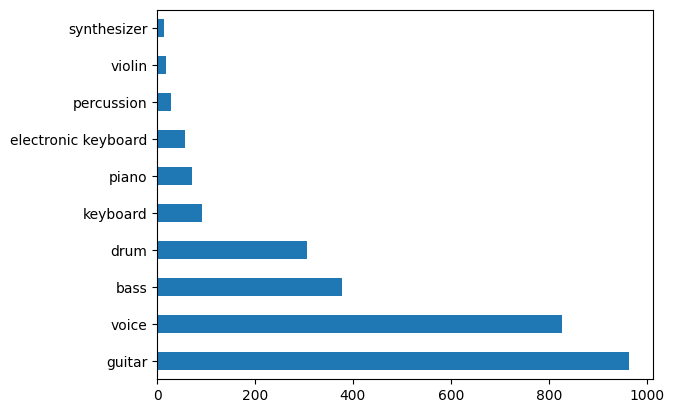

In [11]:
instrument_count.head(10).plot(kind='barh')